In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
import time

RANDOM_STATE_SEED = 12 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("./drive/MyDrive/CICIDS2018.csv", low_memory=False)

In [4]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [5]:
# drop missing values
df.dropna(inplace=True)

In [6]:
df["Label"].value_counts()

DDOS attack-HOIC        686012
Benign                  360833
DDOS attack-LOIC-UDP      1730
Name: Label, dtype: int64

In [7]:
df.replace(to_replace=["DDOS attack-HOIC", "DDOS attack-LOIC-UDP"], value="Malicious", inplace=True)

In [8]:
df["Label"].value_counts()

Malicious    687742
Benign       360833
Name: Label, dtype: int64

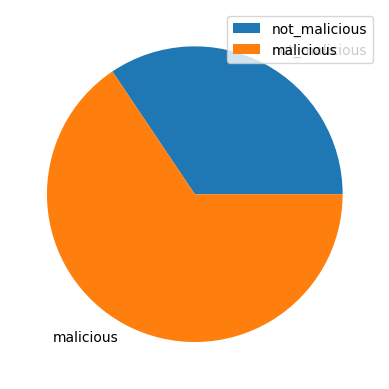

In [9]:
#using matplotlib to plot the label column for pie chart

labels = ["not_malicious","malicious"]


size = [dict(df['Label'].value_counts())['Benign'],dict(df['Label'].value_counts())['Malicious']]
plt.pie(size,labels = labels)

plt.legend(["not_malicious", "malicious"])
plt.show()

In [10]:
print(df.duplicated().sum())

17557


In [11]:
df.drop_duplicates(inplace = True)

In [12]:
print(df.duplicated().sum())

0


In [13]:
df1 = df[df["Label"] == "Benign"][:35985]
df2 = df[df["Label"] == "Malicious"][:35985]
df_equal = pd.concat([ df1,df2], axis =0)

In [14]:
df_equal.replace(to_replace="Benign", value=0, inplace=True)
df_equal.replace(to_replace="Malicious", value=1, inplace=True)

In [15]:
train, test = train_test_split(df_equal, test_size=0.3, random_state=RANDOM_STATE_SEED)

In [16]:
min_max_scaler = MinMaxScaler().fit(train[['Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']])

In [17]:
numerical_columns = ['Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

In [18]:
train[numerical_columns] = min_max_scaler.transform(train[numerical_columns])

In [19]:
train.drop(['Timestamp'], axis=1,inplace=True)
test.drop(['Timestamp'],axis=1,inplace=True)

In [20]:
test[numerical_columns] = min_max_scaler.transform(test[numerical_columns])

In [21]:
print("Full dataset:\n")
print("Benign: " + str(df_equal["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(df_equal["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Training set:\n")
print("Benign: " + str(train["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(train["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Test set:\n")
print("Benign: " + str(test["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(test["Label"].value_counts()[[1]].sum()))

Full dataset:

Benign: 35985
Malicious: 35985
---------------
Training set:

Benign: 25166
Malicious: 25213
---------------
Test set:

Benign: 10819
Malicious: 10772


In [22]:
y_train = np.array(train.pop("Label"))# pop removes "Label" from the dataframe
#y_train = np.array(train.pop("Timestamp"))
X_train = train.values

In [23]:
y_test = np.array(test.pop("Label")) # pop removes "Label" from the dataframe
#y_test = np.array(test.pop("Timestamp"))
X_test = test.values

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#creating a logisticregression object
start_time = time.perf_counter()
LR = LogisticRegression(max_iter=1000)

#train the model using the training the data
LR.fit(X_train, y_train)
end_time = time.perf_counter()

#predict the classes of test data
y_pred = LR.predict(X_test)

# calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# compute F1 score
f1 = f1_score(y_test, y_pred)
print('F1 score:', f1)

# compute precision
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

# compute recall
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# compute classification report
report = classification_report(y_test, y_pred)
print('Classification report:\n', report)

# compute confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', confusion)

# Calculate the computation time
computation_time = end_time - start_time
print("Computation time:", computation_time, "seconds")

Accuracy: 0.9993052660830902
F1 score: 0.9993042348903011
Precision: 0.9986094372856216
Recall: 1.0
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10819
           1       1.00      1.00      1.00     10772

    accuracy                           1.00     21591
   macro avg       1.00      1.00      1.00     21591
weighted avg       1.00      1.00      1.00     21591

Confusion matrix:
 [[10804    15]
 [    0 10772]]
Computation time: 10.096357708999989 seconds


In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

start_time = time.perf_counter()
#now initializing KNN
KNN = KNeighborsClassifier(n_neighbors = 5)

#train the KNN model
KNN.fit(X_train,y_train)
end_time = time.perf_counter()

# calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# compute F1 score
f1 = f1_score(y_test, y_pred)
print('F1 score:', f1)

# compute precision
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

# compute recall
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# compute classification report
report = classification_report(y_test, y_pred)
print('Classification report:\n', report)

# compute confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', confusion)

# Calculate the computation time
computation_time = end_time - start_time
print("Computation time:", computation_time, "seconds")

Accuracy: 0.9993052660830902
F1 score: 0.9993042348903011
Precision: 0.9986094372856216
Recall: 1.0
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10819
           1       1.00      1.00      1.00     10772

    accuracy                           1.00     21591
   macro avg       1.00      1.00      1.00     21591
weighted avg       1.00      1.00      1.00     21591

Confusion matrix:
 [[10804    15]
 [    0 10772]]
Computation time: 0.03158385800000474 seconds


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

start_time = time.perf_counter()
dt = DecisionTreeClassifier(random_state=42)

# train the model using the training data
dt.fit(X_train, y_train)
end_time = time.perf_counter()

# calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# compute F1 score
f1 = f1_score(y_test, y_pred)
print('F1 score:', f1)

# compute precision
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

# compute recall
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# compute classification report
report = classification_report(y_test, y_pred)
print('Classification report:\n', report)

# compute confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', confusion)

# Calculate the computation time
computation_time = end_time - start_time
print("Computation time:", computation_time, "seconds")

Accuracy: 0.9993052660830902
F1 score: 0.9993042348903011
Precision: 0.9986094372856216
Recall: 1.0
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10819
           1       1.00      1.00      1.00     10772

    accuracy                           1.00     21591
   macro avg       1.00      1.00      1.00     21591
weighted avg       1.00      1.00      1.00     21591

Confusion matrix:
 [[10804    15]
 [    0 10772]]
Computation time: 0.31277347399998234 seconds


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


start_time = time.perf_counter()
rf = RandomForestClassifier(random_state=42)

# train the model using the training data
rf.fit(X_train, y_train)
end_time = time.perf_counter()

# predict the classes of test data
y_pred = rf.predict(X_test)

# calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# compute F1 score
f1 = f1_score(y_test, y_pred)
print('F1 score:', f1)

# compute precision
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

# compute recall
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# compute classification report
report = classification_report(y_test, y_pred)
print('Classification report:\n', report)

# compute confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', confusion)

# Calculate the computation time
computation_time = end_time - start_time
print("Computation time:", computation_time, "seconds")

Accuracy: 0.999861053216618
F1 score: 0.9998607694806702
Precision: 0.9997215777262181
Recall: 1.0
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10819
           1       1.00      1.00      1.00     10772

    accuracy                           1.00     21591
   macro avg       1.00      1.00      1.00     21591
weighted avg       1.00      1.00      1.00     21591

Confusion matrix:
 [[10816     3]
 [    0 10772]]
Computation time: 4.882783208999996 seconds


In [28]:
from sklearn.ensemble import GradientBoostingClassifier

start_time = time.perf_counter()
# create a Gradient Boosting Classifier object
gb = GradientBoostingClassifier(random_state=42)

# train the model using the training data
gb.fit(X_train, y_train)
end_time = time.perf_counter()

# predict the classes of test data
y_pred = gb.predict(X_test)

# calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# compute F1 score
f1 = f1_score(y_test, y_pred)
print('F1 score:', f1)

# compute precision
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

# compute recall
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

# compute classification report
report = classification_report(y_test, y_pred)
print('Classification report:\n', report)

# compute confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', confusion)

# Calculate the computation time
computation_time = end_time - start_time
print("Computation time:", computation_time, "seconds")

Accuracy: 1.0
F1 score: 1.0
Precision: 1.0
Recall: 1.0
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10819
           1       1.00      1.00      1.00     10772

    accuracy                           1.00     21591
   macro avg       1.00      1.00      1.00     21591
weighted avg       1.00      1.00      1.00     21591

Confusion matrix:
 [[10819     0]
 [    0 10772]]
Computation time: 37.390208629 seconds


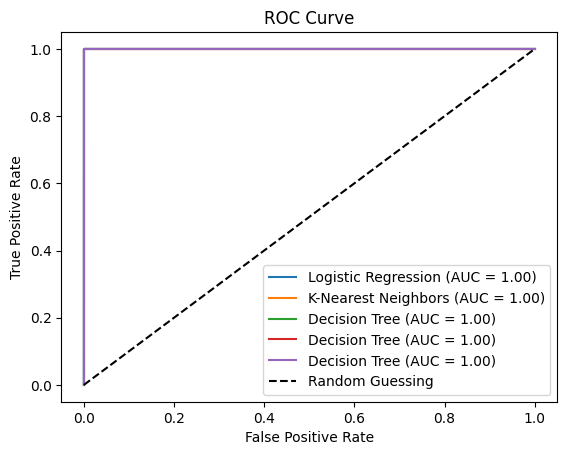

In [29]:
# Plot the AUC curve
lr_prob = LR.predict_proba(X_test)[:, 1]
knn_prob = KNN.predict_proba(X_test)[:, 1]
dt_prob = dt.predict_proba(X_test)[:, 1]
gb_prob = gb.predict_proba(X_test)[:, 1]
rf_prob = rf.predict_proba(X_test)[:, 1]

lr_fpr, lr_tpr, thresholds0 = roc_curve(y_test, lr_prob)
knn_fpr, knn_tpr, thresholds1 = roc_curve(y_test, knn_prob)
dt_fpr, dt_tpr, thresholds2 = roc_curve(y_test, dt_prob)
gb_fpr, gb_tpr, thresholds3 = roc_curve(y_test, gb_prob)
rf_fpr, rf_tpr, thresholds4 = roc_curve(y_test, rf_prob)

# calculate ROC AUC score
lr_auc = roc_auc_score(y_test, lr_prob)
knn_auc = roc_auc_score(y_test, knn_prob)
dt_auc = roc_auc_score(y_test, gb_prob)
gb_auc = roc_auc_score(y_test, rf_prob)
rf_auc = roc_auc_score(y_test, dt_prob)


# plot ROC curves
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC = {lr_auc:.2f})")
plt.plot(knn_fpr, knn_tpr, label=f"K-Nearest Neighbors (AUC = {knn_auc:.2f})")
plt.plot(dt_fpr, dt_tpr, label=f"Decision Tree (AUC = {dt_auc:.2f})")
plt.plot(gb_fpr, gb_tpr, label=f"Decision Tree (AUC = {dt_auc:.2f})")
plt.plot(rf_fpr, rf_tpr, label=f"Decision Tree (AUC = {dt_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [30]:
# from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier(n_estimators=60)

# parameters = {'n_estimators': [50, 100, 150], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4]}

# grid_search = GridSearchCV(estimator = rf, param_grid=parameters, scoring='accuracy', cv=4, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# best_accuracy = grid_search.best_score_
# best_parameters = grid_search.best_params_

# print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
# print("Best Parameters:", best_parameters)